<a href="https://colab.research.google.com/github/ChenYP-1982/Fraud/blob/main/Fraud_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture

%pip install lightgbm

# Importing Libraries

In [92]:
#Manipulacao e Dataviz

import pandas as pd
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
from pandas.io.formats.style import Styler
import seaborn as sns


#Preprocessing e modeling

from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import (train_test_split as tts,
                                     GridSearchCV as gsv,
                                     RandomizedSearchCV as rsv,
                                     cross_validate as cv)
from sklearn import metrics
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler,
                                   StandardScaler,
                                   PowerTransformer)

from sklearn.compose import ColumnTransformer
from sklearn.impute import (KNNImputer,
                            SimpleImputer)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
#Evaluation

from sklearn import metrics

from yellowbrick.classifier import (ConfusionMatrix,
                                    ROCAUC,
                                    ClassificationReport,
                                    discrimination_threshold,
                                    classification_report
                                    )

from yellowbrick.features import feature_importances


import warnings

warnings.filterwarnings("ignore")



import sklearn

In [5]:
sklearn.set_config("diagram")
warnings.filterwarnings("ignore")

In [6]:
def calculate_metrics(model, X, y):
        y_pred = model.predict(X)

        model_metrics = {
        'accuracy': metrics.accuracy_score(y, y_pred),
        'balanced_accuracy': metrics.balanced_accuracy_score(y, y_pred),
        'precision': metrics.precision_score(y, y_pred),
        'recall': metrics.recall_score(y, y_pred),
        'f1': metrics.f1_score(y, y_pred),
    }

        try:
            y_pred_proba = model.predict_proba(X)[:,1]
            model_metrics['roc-auc'] = metrics.roc_auc_score(y, y_pred_proba)
            return model_metrics
        except:
            return model_metrics

In [7]:
def age_seg(df: pd.DataFrame) -> pd.DataFrame:
    conditions = [
        (df['age'] < 18),
        ((df['age'] >= 18) & (df['age'] < 30)),
        ((df['age'] >= 30) & (df['age'] < 40)),
        ((df['age'] >= 40) & (df['age'] < 50)),
        ((df['age'] >= 50) & (df['age'] < 60)),
        ((df['age'] >= 60) & (df['age'] < 70)),
        ((df['age'] >= 70) & (df['age'] < 80)),
        ((df['age'] >= 80) & (df['age'] < 90)),
        (df['age'] >= 90)
    ]

    values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Create a new column 'age_seg' based on the conditions
    df['age_seg'] = np.select(conditions, values, default=np.nan)

    return df


def dt_engineering(df:pd.DataFrame)->pd.DataFrame:
  df["year"]=df.trans_date_trans_time.dt.year
  df["month"]=df.trans_date_trans_time.dt.month
  df["day_name"]=df.trans_date_trans_time.dt.day_name()
  df["hour"]=df.trans_date_trans_time.dt.hour
  df["quarter"]=df.trans_date_trans_time.dt.quarter
  df["q_end"]=df.trans_date_trans_time.dt.is_quarter_end
  df["min"]=df.trans_date_trans_time.dt.minute
  df["date"]=pd.to_datetime(df["trans_date_trans_time"]).dt.date
  return df

In [8]:
date.today()

datetime.date(2024, 1, 2)

0: No fraud
1:Fraud

# EDA

In [9]:

df=pd.read_csv("/content/Fraud.csv", sep=";", parse_dates=True,usecols=["trans_date_trans_time",
                                                                            "merchant","category",
                                                                            "amt","first_name",
                                                                            "last_name","gender",
                                                                            "city","state","job",
                                                                            "dob","is_fraud"] )

In [10]:

hold_out=df.sample(n=475719,random_state=101).index

def splitdf()->pd.DataFrame:

  df_train=(df.loc[~df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  )


  df_holdout=(df.loc[df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  )


  return df_train, df_holdout

df_train,df_holdout=splitdf()

In [11]:
df_train

,trans_date_trans_time,merchant,category,amt,first_name,last_name,gender,city,state,job,dob,is_fraud
0,28/12/2020 17:01,"fraud_Weimann, Kuhic and Beahan",shopping_pos,263.78,Ashley,Cabrera,F,Vero Beach,FL,"Librarian, public",07/05/1986,0
1,11/11/2020 20:20,"fraud_Romaguera, Wehner and Tromp",kids_pets,15.18,Sarah,Bishop,F,Meridian,TX,Phytotherapist,12/11/1970,0
2,23/08/2020 21:55,fraud_Waelchi-Wolf,kids_pets,7.74,Amber,Perez,F,Fulton,SD,Financial adviser,26/06/1955,0
3,01/12/2020 15:55,fraud_Conroy Ltd,shopping_pos,2.30,Julia,Bell,F,West Sayville,NY,Film/video editor,25/06/1990,0
4,09/11/2020 20:06,"fraud_O'Connell, Botsford and Hand",home,5.55,Janet,Turner,F,Shields,ND,Film/video editor,17/12/1989,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,18/11/2020 20:00,fraud_Collier LLC,home,47.27,Amanda,Jones,F,Queenstown,MD,Maintenance engineer,06/12/1962,0
79996,02/11/2020 03:13,fraud_Kunze Inc,grocery_pos,118.07,Steven,Sanders,M,Ozawkie,KS,Theatre director,14/11/1948,0
79997,05/07/2020 00:59,"fraud_Bernhard, Grant and Langworth",shopping_pos,126.40,Aaron,Murray,M,Meadville,MO,Tourist information centre manager,23/12/1974,0
79998,21/12/2020 20:38,fraud_Shields-Wunsch,health_fitness,6.39,Destiny,Lowe,F,Hannawa Falls,NY,Chief Executive Officer,05/06/1991,0


In [12]:
df_train["merchant"]=df_train["merchant"].str.strip("fraud_")
df_holdout["merchant"]=df_holdout["merchant"].str.strip("fraud_")
df["merchant"]=df["merchant"].str.strip("fraud_")

In [13]:
df_train.shape

(80000, 12)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  80000 non-null  object 
 1   merchant               80000 non-null  object 
 2   category               80000 non-null  object 
 3   amt                    80000 non-null  float64
 4   first_name             80000 non-null  object 
 5   last_name              80000 non-null  object 
 6   gender                 80000 non-null  object 
 7   city                   80000 non-null  object 
 8   state                  80000 non-null  object 
 9   job                    80000 non-null  object 
 10  dob                    80000 non-null  object 
 11  is_fraud               80000 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 7.3+ MB


In [15]:
#droping na
df_train=df_train.dropna()
df_holdout=df_holdout.dropna()
df=df.dropna()

In [16]:
#parse date as date
df_train.trans_date_trans_time=pd.to_datetime(df_train.trans_date_trans_time)
df_holdout.trans_date_trans_time=pd.to_datetime(df_holdout.trans_date_trans_time)
df.trans_date_trans_time=pd.to_datetime(df.trans_date_trans_time)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  80000 non-null  datetime64[ns]
 1   merchant               80000 non-null  object        
 2   category               80000 non-null  object        
 3   amt                    80000 non-null  float64       
 4   first_name             80000 non-null  object        
 5   last_name              80000 non-null  object        
 6   gender                 80000 non-null  object        
 7   city                   80000 non-null  object        
 8   state                  80000 non-null  object        
 9   job                    80000 non-null  object        
 10  dob                    80000 non-null  object        
 11  is_fraud               80000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory

In [18]:
df_train.isna().sum()

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
first_name               0
last_name                0
gender                   0
city                     0
state                    0
job                      0
dob                      0
is_fraud                 0
dtype: int64

In [19]:
#cardinalidade
df_train.nunique()

trans_date_trans_time    67768
merchant                   693
category                    14
amt                      19252
first_name                 340
last_name                  471
gender                       2
city                       845
state                       50
job                        478
dob                        906
is_fraud                     2
dtype: int64

In [20]:
#nao temos valores duplicados
df_train[df_train.duplicated()]

,trans_date_trans_time,merchant,category,amt,first_name,last_name,gender,city,state,job,dob,is_fraud


In [21]:
#percentual de desbalaceamento de dados
print(f"Desbalanceamento do dados do df_train \n{df_train.is_fraud.value_counts(normalize=True).round(4)}")
print(f"Desbalanceamento do dados do df_holdout \n{df_holdout.is_fraud.value_counts(normalize=True).round(4)}")
print(f"Desbalanceamento do dados do df_holdout \n{df.is_fraud.value_counts(normalize=True).round(4)}")


Desbalanceamento do dados do df_train 
0    0.9962
1    0.0038
Name: is_fraud, dtype: float64
Desbalanceamento do dados do df_holdout 
0    0.9961
1    0.0039
Name: is_fraud, dtype: float64
Desbalanceamento do dados do df_holdout 
0    0.9961
1    0.0039
Name: is_fraud, dtype: float64


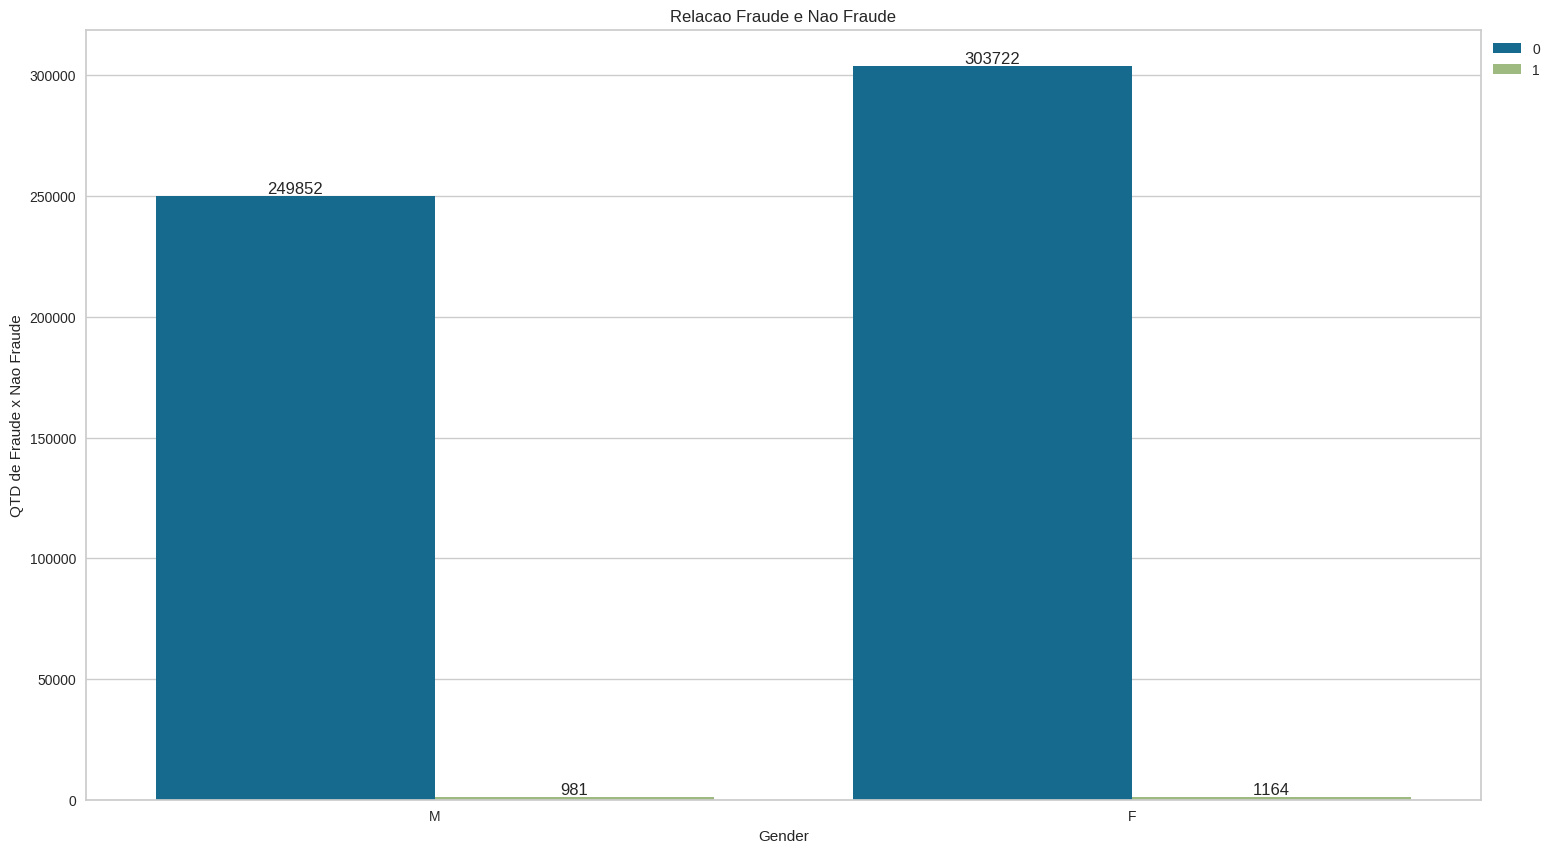

In [22]:
plt.figure(figsize=(18,10))
ax=sns.countplot(data=df, x="gender", hue="is_fraud")
ax.set_xlabel("Gender")
ax.set_ylabel("QTD de Fraude x Nao Fraude")
ax.set_title("Relacao Fraude e Nao Fraude")
for label in ax.containers:
  ax.bar_label(label)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


#Feauture engineering

In [23]:
#criando coluna adicional age
df_train['dob'] = pd.to_datetime(df_train['dob'])
df_train["age"]=(pd.to_datetime(date.today()) -  df_train['dob']).astype('<m8[Y]')

df_holdout['dob'] = pd.to_datetime(df_holdout['dob'])
df_holdout["age"]=(pd.to_datetime(date.today()) -  df_holdout['dob']).astype('<m8[Y]')

df['dob'] = pd.to_datetime(df['dob'])
df["age"]=(pd.to_datetime(date.today()) -  df['dob']).astype('<m8[Y]')

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  80000 non-null  datetime64[ns]
 1   merchant               80000 non-null  object        
 2   category               80000 non-null  object        
 3   amt                    80000 non-null  float64       
 4   first_name             80000 non-null  object        
 5   last_name              80000 non-null  object        
 6   gender                 80000 non-null  object        
 7   city                   80000 non-null  object        
 8   state                  80000 non-null  object        
 9   job                    80000 non-null  object        
 10  dob                    80000 non-null  datetime64[ns]
 11  is_fraud               80000 non-null  int64         
 12  age                    80000 non-null  float64       
dtypes

In [25]:
def dt_engineering(df:pd.DataFrame)->pd.DataFrame:
  df["year"]=df.trans_date_trans_time.dt.year
  df["month"]=df.trans_date_trans_time.dt.month
  df["day_name"]=df.trans_date_trans_time.dt.day_name()
  df["hour"]=df.trans_date_trans_time.dt.hour
  df["quarter"]=df.trans_date_trans_time.dt.quarter
  df["q_end"]=df.trans_date_trans_time.dt.is_quarter_end
  df["min"]=df.trans_date_trans_time.dt.minute
  df["date"]=pd.to_datetime(df["trans_date_trans_time"]).dt.date
  return df

df_train=dt_engineering(df_train)
df_holdout=dt_engineering(df_holdout)
df=dt_engineering(df)


In [26]:
df_train.head()

,trans_date_trans_time,merchant,category,amt,first_name,last_name,gender,city,state,job,...,is_fraud,age,year,month,day_name,hour,quarter,q_end,min,date
0,2020-12-28 17:01:00,"Weimann, Kuhic and Beahan",shopping_pos,263.78,Ashley,Cabrera,F,Vero Beach,FL,"Librarian, public",...,0,37.0,2020,12,Monday,17,4,False,1,2020-12-28
1,2020-11-11 20:20:00,"Romaguera, Wehner and Tromp",kids_pets,15.18,Sarah,Bishop,F,Meridian,TX,Phytotherapist,...,0,53.0,2020,11,Wednesday,20,4,False,20,2020-11-11
2,2020-08-23 21:55:00,Waelchi-Wol,kids_pets,7.74,Amber,Perez,F,Fulton,SD,Financial adviser,...,0,68.0,2020,8,Sunday,21,3,False,55,2020-08-23
3,2020-01-12 15:55:00,Conroy Lt,shopping_pos,2.30,Julia,Bell,F,West Sayville,NY,Film/video editor,...,0,33.0,2020,1,Sunday,15,1,False,55,2020-01-12
4,2020-09-11 20:06:00,"O'Connell, Botsford and Han",home,5.55,Janet,Turner,F,Shields,ND,Film/video editor,...,0,34.0,2020,9,Friday,20,3,False,6,2020-09-11


In [27]:
df_train.age.describe()

count    80000.000000
mean        49.680200
std         17.416782
min         18.000000
25%         36.000000
50%         48.000000
75%         61.000000
max         99.000000
Name: age, dtype: float64

In [28]:

# Apply age segmentation to df_train/ df_holdout
df_train = age_seg(df_train)
df_holdout=age_seg(df_holdout)
df=age_seg(df)

In [29]:
df_train.head()

,trans_date_trans_time,merchant,category,amt,first_name,last_name,gender,city,state,job,...,age,year,month,day_name,hour,quarter,q_end,min,date,age_seg
0,2020-12-28 17:01:00,"Weimann, Kuhic and Beahan",shopping_pos,263.78,Ashley,Cabrera,F,Vero Beach,FL,"Librarian, public",...,37.0,2020,12,Monday,17,4,False,1,2020-12-28,3.0
1,2020-11-11 20:20:00,"Romaguera, Wehner and Tromp",kids_pets,15.18,Sarah,Bishop,F,Meridian,TX,Phytotherapist,...,53.0,2020,11,Wednesday,20,4,False,20,2020-11-11,5.0
2,2020-08-23 21:55:00,Waelchi-Wol,kids_pets,7.74,Amber,Perez,F,Fulton,SD,Financial adviser,...,68.0,2020,8,Sunday,21,3,False,55,2020-08-23,6.0
3,2020-01-12 15:55:00,Conroy Lt,shopping_pos,2.30,Julia,Bell,F,West Sayville,NY,Film/video editor,...,33.0,2020,1,Sunday,15,1,False,55,2020-01-12,3.0
4,2020-09-11 20:06:00,"O'Connell, Botsford and Han",home,5.55,Janet,Turner,F,Shields,ND,Film/video editor,...,34.0,2020,9,Friday,20,3,False,6,2020-09-11,3.0


# Entendedno sobre a dinamica das fraudes

In [30]:
df_cat_fraud=(df.groupby(["category"]).agg(qtd_transferencias=("is_fraud","count"),
                      pct_quantidade=("is_fraud",lambda x:x.count()/len(df)*100),
                      qtd_fraude=("is_fraud","sum"),
                      avg_transfer=("amt","mean"))
.sort_values(by="qtd_fraude", ascending=False)

)
df_cat_fraud["relacao_trans_x_fraude"]=(df_cat_fraud["qtd_fraude"]/df_cat_fraud["qtd_transferencias"])*100

df_cat_fraud.sort_values(by="relacao_trans_x_fraude", ascending=False)

,qtd_transferencias,pct_quantidade,qtd_fraude,avg_transfer,relacao_trans_x_fraude
category,,,,,
shopping_net,41779,7.518008,506,83.481653,1.211135
misc_net,27367,4.924611,267,78.600237,0.975628
grocery_pos,52553,9.456758,485,115.885327,0.922878
shopping_pos,49791,8.959744,213,76.862457,0.427788
gas_transport,56370,10.143616,154,63.577001,0.273195
travel,17449,3.139896,40,112.389683,0.229239
grocery_net,19426,3.495652,41,53.731667,0.211057
misc_pos,34574,6.221490,72,62.182246,0.208249
personal_care,39327,7.076778,70,48.233021,0.177995


In [31]:
#fraude por iddade
df_age_fraud=(df.groupby(["age"]).agg(qtd_transferencias=("is_fraud","count"),
                      pct_quantidade=("is_fraud",lambda x:x.count()/len(df)*100),
                      qtd_fraude=("is_fraud","sum"),
                      avg_transfer=("amt","mean"))
.sort_values(by="qtd_fraude", ascending=False)

)

In [32]:
df.is_fraud.value_counts(normalize=True)*100

0    99.614014
1     0.385986
Name: is_fraud, dtype: float64

In [33]:
#criando coluna extra de relacao quantidade de fraude x quantidade de transferencias

df_age_fraud["relacao_fraud_x_transferencia"]=(df_age_fraud.qtd_fraude/df_age_fraud.qtd_transferencias)*100

In [34]:
#alguma idades temos uma possibildade de fraude muito maior que o baseline, como exemplo 21 anos, 99 anos, 80 anos

df_age_fraud= df_age_fraud.sort_values(by="relacao_fraud_x_transferencia", ascending=False).head(10)

df_age_fraud


,qtd_transferencias,pct_quantidade,qtd_fraude,avg_transfer,relacao_fraud_x_transferencia
age,,,,,
21.0,12,0.002159,12,666.145000,100.000000
99.0,199,0.035809,7,85.007638,3.517588
80.0,1511,0.271900,22,69.918537,1.455989
55.0,7350,1.322611,76,69.243423,1.034014
87.0,2646,0.476140,26,69.855775,0.982615
64.0,7505,1.350503,64,69.176378,0.852765
91.0,869,0.156374,7,67.993786,0.805524
60.0,5813,1.046032,46,67.693941,0.791330
88.0,2871,0.516628,22,65.780850,0.766284


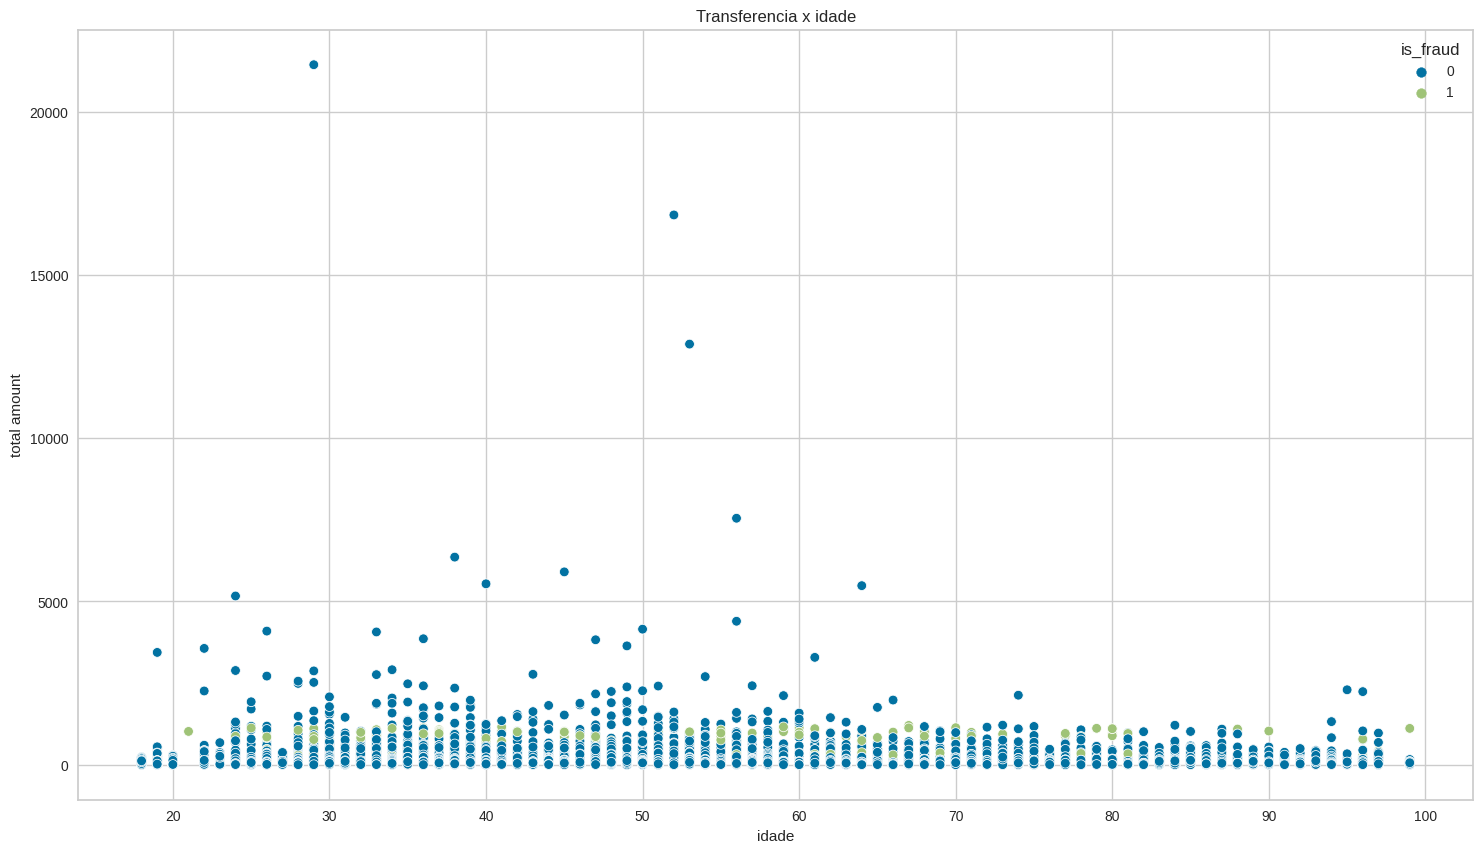

In [35]:
#figura mostrando distribuicao de idade x fraude
fig, ax = plt.subplots(figsize=(18, 10))
ax=sns.scatterplot(data=df_train, x="age", y="amt",hue="is_fraud")
ax.set_ylabel("total amount")
ax.set_xlabel("idade")
ax.set_title("Transferencia x idade")

plt.show()


In [36]:
#fraudes por generos
df_gender_fraud=(df.groupby(["gender","age"]).agg(qtd_transferencias=("is_fraud","count"),
                      pct_quantidade=("is_fraud",lambda x:x.count()/len(df)*100),
                      qtd_fraude=("is_fraud","sum"),
                      avg_transfer=("amt","mean"))
.sort_values(by="qtd_fraude", ascending=False))

In [37]:
df_gender_fraud

qtd_transferencias  pct_quantidade  qtd_fraude  avg_transfer
gender age                                                               
M      37.0                6091        1.096058          57     85.596792
F      51.0               15871        2.855940          52     64.468017
M      30.0                8818        1.586773          48     77.040821
F      29.0                4158        0.748220          47     79.427150
M      64.0                3782        0.680560          46     73.994418
...                         ...             ...         ...           ...
       25.0                2011        0.361874           0     48.494898
       27.0                1428        0.256964           0     69.322080
       28.0                4387        0.789428           0     55.229435
       31.0                1513        0.272260           0     83.259518
       20.0                1858        0.334342           0     65.156534

[156 rows x 4 columns]

In [38]:
df_gender_fraud["relacao_fraud_x_transferencia"]=(df_gender_fraud.qtd_fraude/df_gender_fraud.qtd_transferencias)*100

df_gender_fraud.sort_values("relacao_fraud_x_transferencia", ascending=False)

qtd_transferencias  pct_quantidade  qtd_fraude  avg_transfer  \
gender age                                                                  
M      21.0                  12        0.002159          12    666.145000   
F      79.0                   8        0.001440           8    458.892500   
M      99.0                 199        0.035809           7     85.007638   
F      80.0                 633        0.113906          12     77.977962   
M      55.0                2689        0.483878          43     67.808944   
...                         ...             ...         ...           ...   
F      86.0                 436        0.078457           0     55.198096   
       27.0                1388        0.249767           0     52.099063   
       30.0                3693        0.664544           0     85.731170   
       31.0                5030        0.905134           0     85.720974   
M      20.0                1858        0.334342           0     65.156534   

             relacao_fraud_x_transferencia  
gender age                                  
M      21.0                     100.000000  
F      79.0                     100.000000  
M      99.0                       3.517588  
F      80.0                       1.895735  
M      55.0                       1.599107  
...                                    ...  
F      86.0                       0.000000  
       27.0                       0.000000  
       30.0                       0.000000  
       31.0                       0.000000  
M      20.0                       0.000000  

[156 rows x 5 columns]

In [39]:
#entendendo como esta a distribuicao de fraudes por mes

df_fraud=df.loc[df["is_fraud"]==1].set_index("date")

df_fraud.index=pd.to_datetime(df_fraud.index)

df_fraud=df_fraud.drop(columns=["trans_date_trans_time","first_name","last_name"])


In [40]:
df_fraud.head()

,merchant,category,amt,gender,city,state,job,dob,is_fraud,age,year,month,day_name,hour,quarter,q_end,min,age_seg
date,,,,,,,,,,,,,,,,,,
2020-06-21,Hamill-D'Amore,health_fitness,24.84,F,Notrees,TX,Cytogeneticist,1969-09-15,1,54.0,2020,6,Sunday,22,2,False,6,5.0
2020-06-21,"Rodriguez, Yost and Jenkins",misc_net,780.52,M,Benton,WI,Public relations officer,1958-10-09,1,65.0,2020,6,Sunday,22,2,False,32,6.0
2020-06-21,Nienow PLC,entertainment,620.33,M,Benton,WI,Public relations officer,1958-10-09,1,65.0,2020,6,Sunday,22,2,False,37,6.0
2020-06-21,"Heathcote, Yost and Kertzmann",shopping_net,1077.69,M,Denham Springs,LA,Herbalist,1994-05-31,1,29.0,2020,6,Sunday,22,2,False,38,2.0
2020-06-21,Hermann and Sons,shopping_pos,842.65,F,Notrees,TX,Cytogeneticist,1969-09-15,1,54.0,2020,6,Sunday,23,2,False,2,5.0


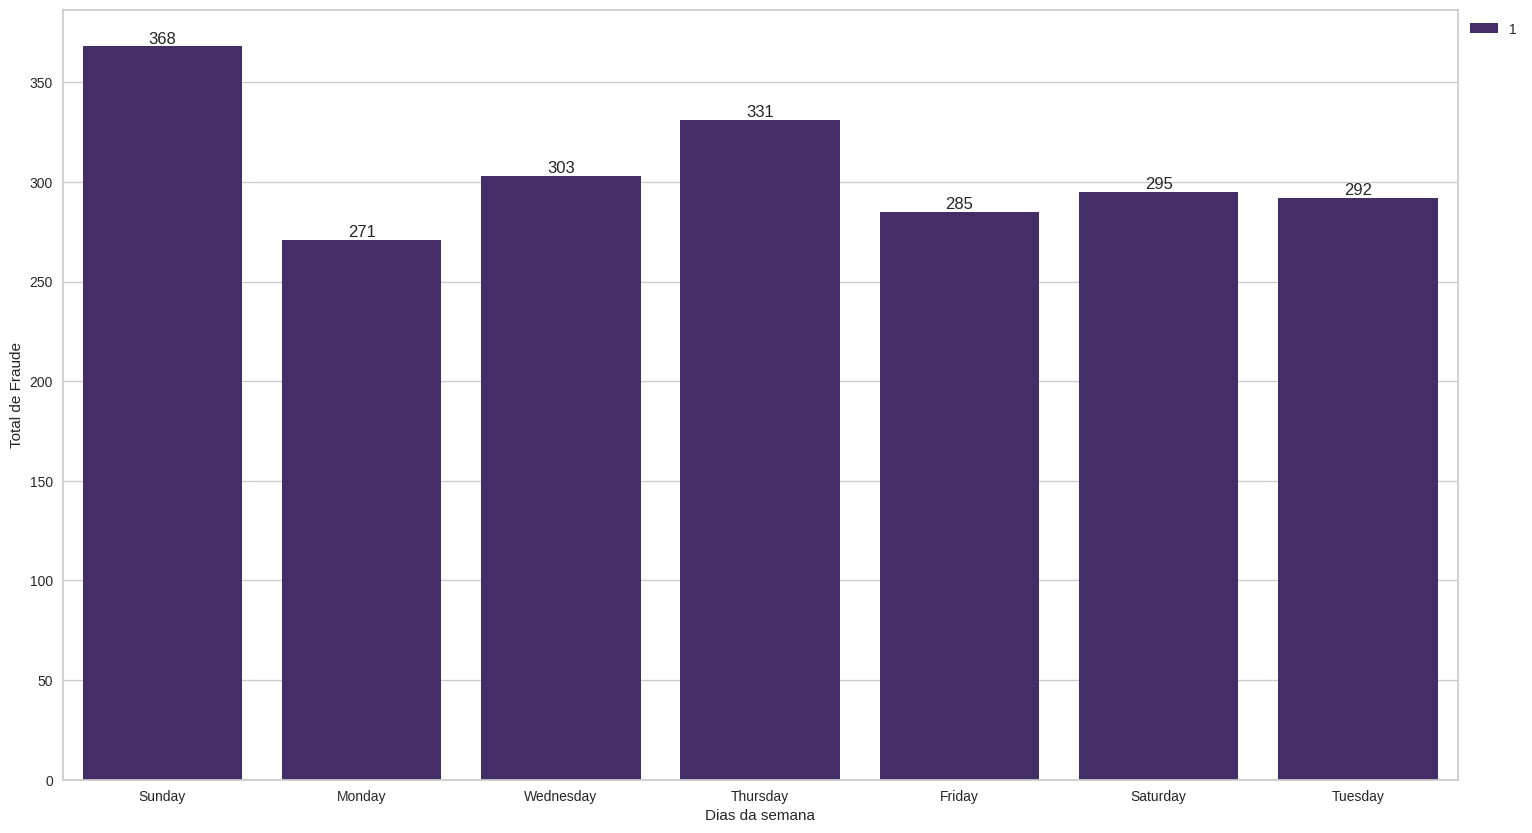

In [41]:
#entendendo quais os dias que acontecem mais fraudes no set de treino
plt.figure(figsize=(18,10))
sns.despine()
ax=sns.countplot(data=df_fraud, x="day_name",  palette=['#432371',"#FAAE7B"],hue="is_fraud")
plt.xlabel("Dias da semana")
plt.ylabel("Total de Fraude")
ax.spines["left"].set_visible(True)
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


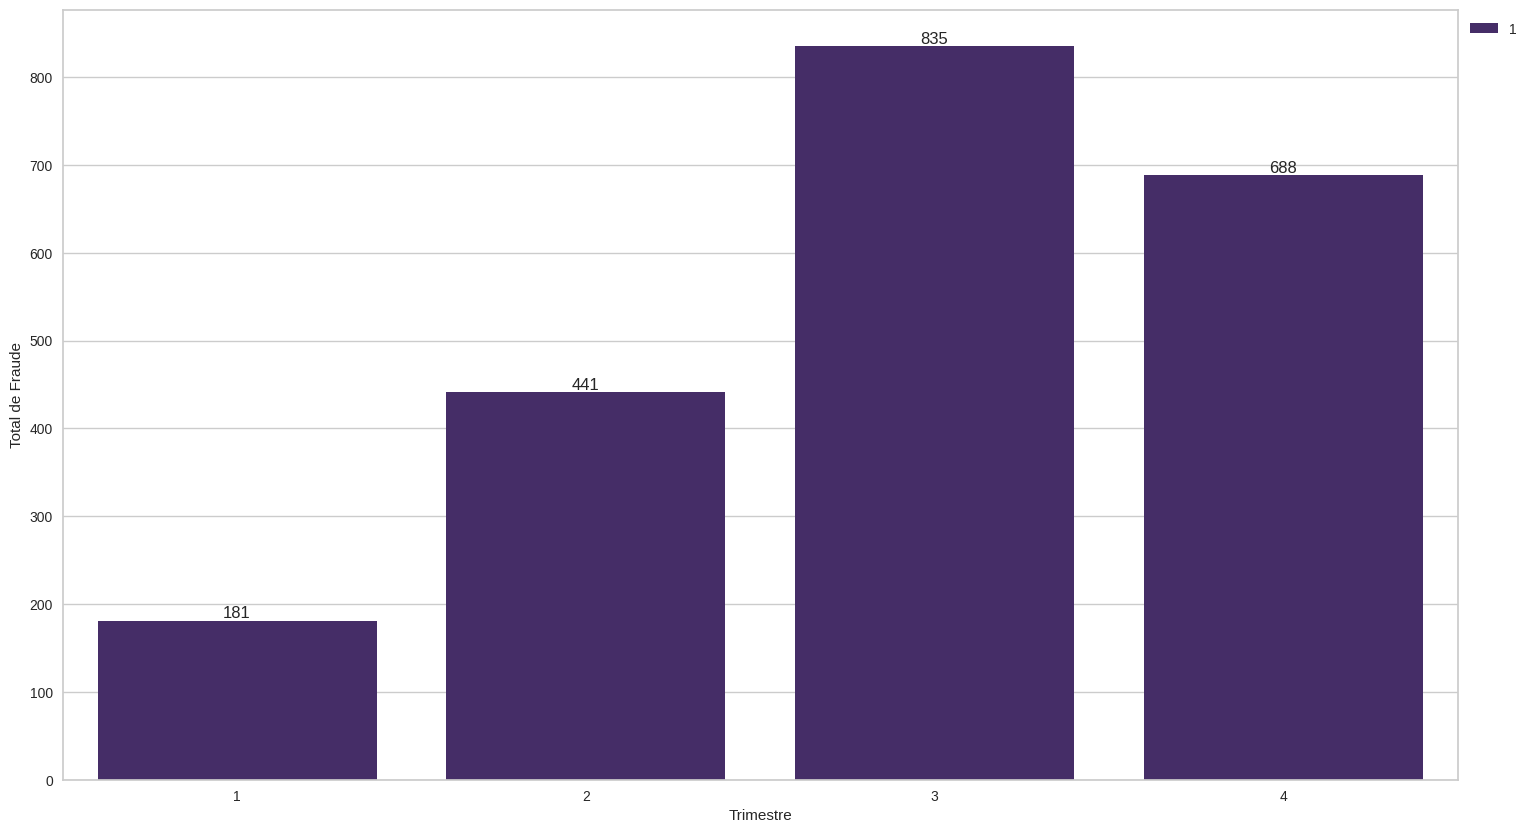

In [42]:
#entendendo quais quarters que acontecem mais fraudes
plt.figure(figsize=(18,10))
sns.despine()
ax=sns.countplot(data=df_fraud, x="quarter",  palette=['#432371',"#FAAE7B"],hue="is_fraud")
plt.xlabel("Trimestre")
plt.ylabel("Total de Fraude")
ax.spines["left"].set_visible(True)
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

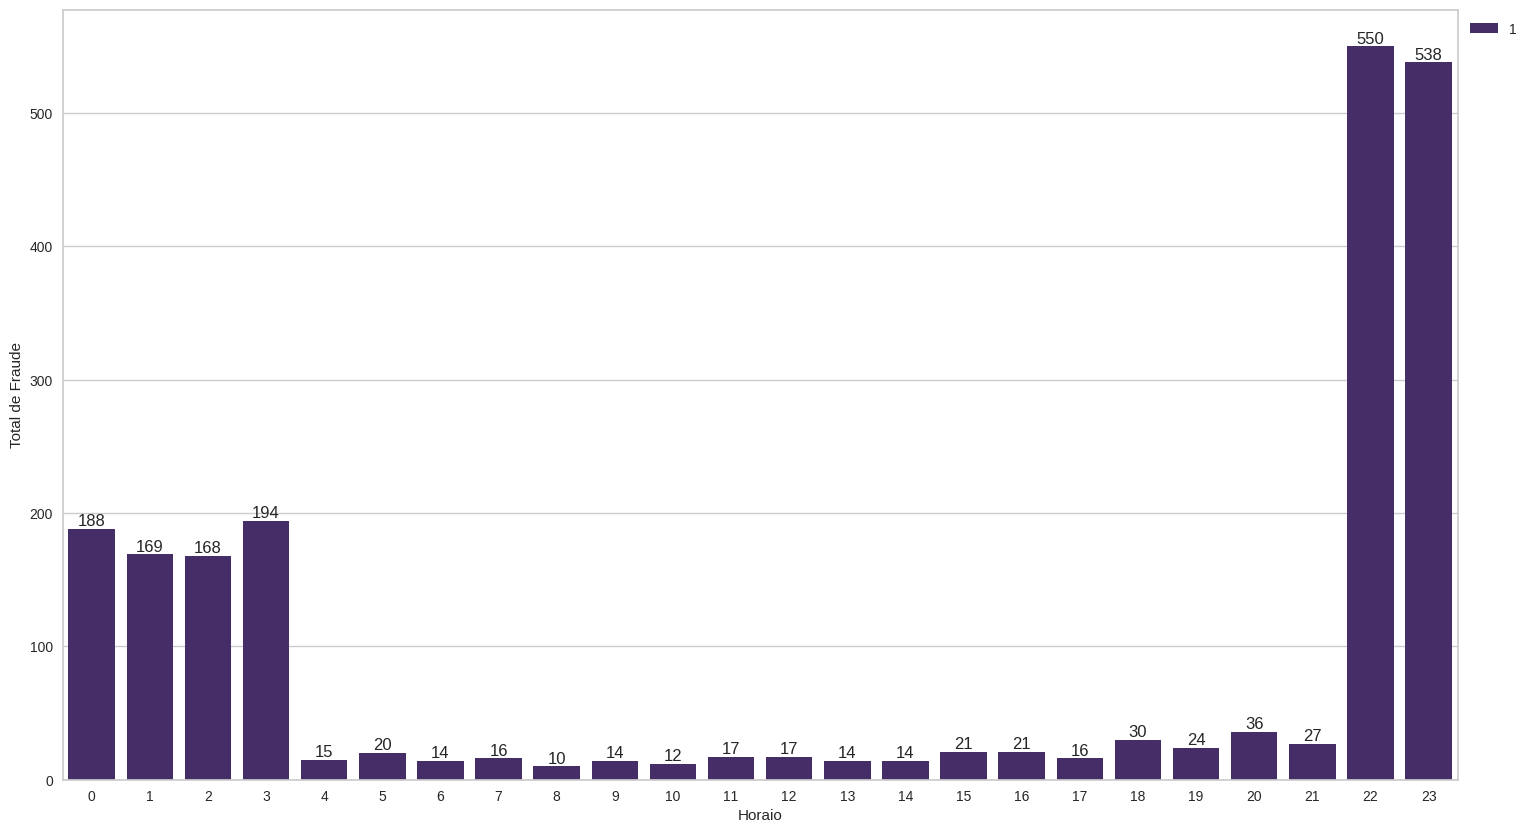

In [43]:
plt.figure(figsize=(18,10))
sns.despine()
ax=sns.countplot(data=df_fraud, x="hour",  palette=['#432371',"#FAAE7B"],hue="is_fraud")
plt.xlabel("Horaio")
plt.ylabel("Total de Fraude")
ax.spines["left"].set_visible(True)
for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [44]:
#entendendo a distribuicao dos valore de tranferencia
df_train.amt.describe()

count    80000.000000
mean        69.095894
std        167.791992
min          1.000000
25%          9.660000
50%         47.320000
75%         82.950000
max      21437.710000
Name: amt, dtype: float64

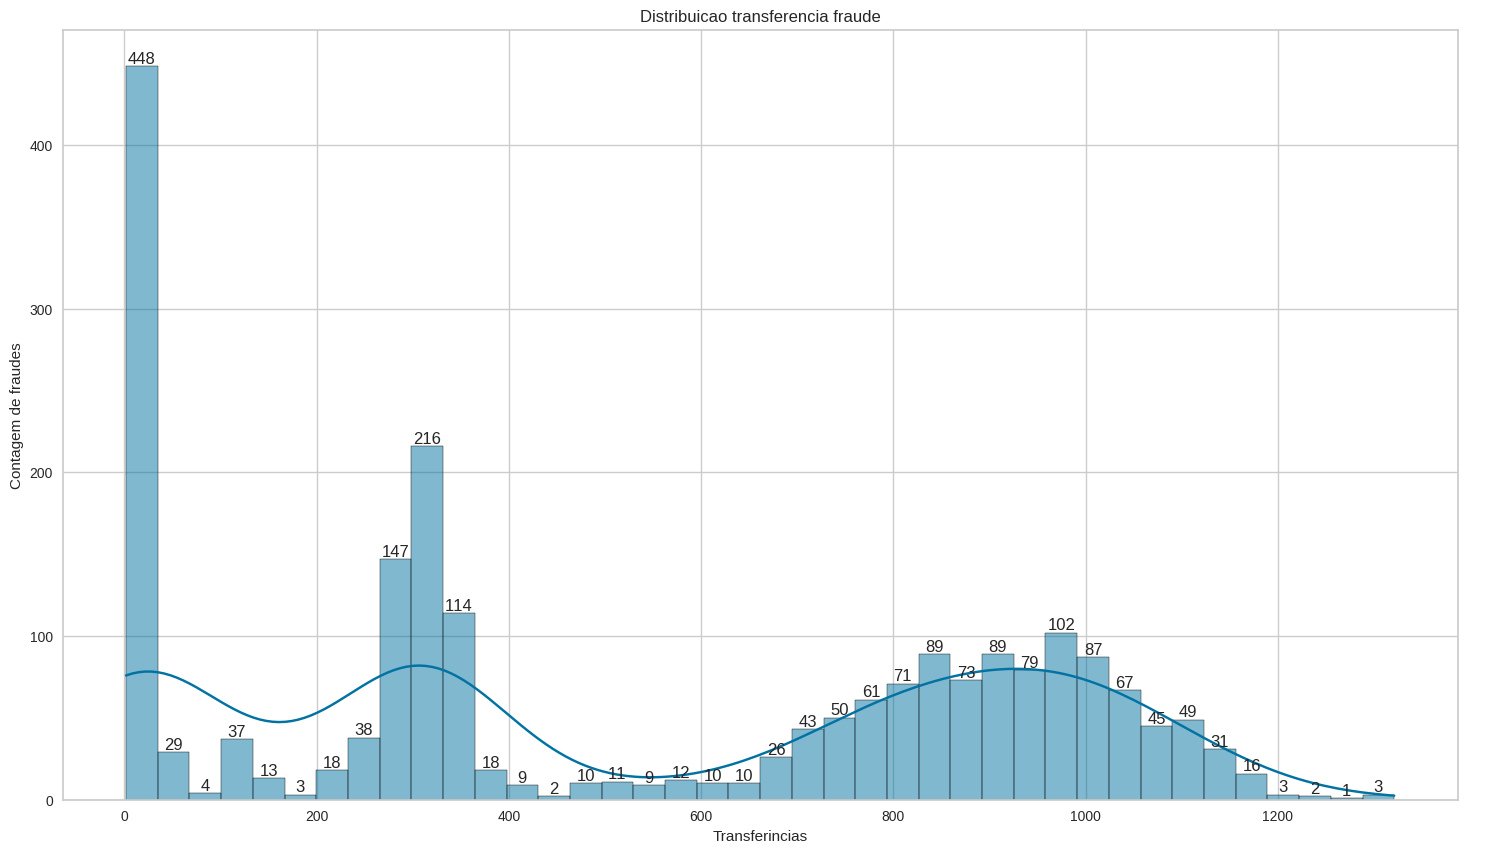

In [45]:
plt.figure(figsize=(18,10))
ax=sns.histplot(data=df_fraud, x="amt", bins=40, kde=True,hue="is_fraud")
plt.title("Distribuicao transferencia fraude")
plt.ylabel("Contagem de fraudes")
plt.xlabel("Transferincias")

for label in ax.containers:
        ax.bar_label(label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# Preprocessing/ Modeling

In [46]:
df_train=df_train.drop(columns=["trans_date_trans_time","first_name","last_name","year","dob"])
df_train=df_train.set_index("date")

df_holdout=df_holdout.drop(columns=["trans_date_trans_time","first_name","last_name","year","dob"])
df_holdout=df_holdout.set_index("date")

In [47]:
df_train

,merchant,category,amt,gender,city,state,job,is_fraud,age,month,day_name,hour,quarter,q_end,min,age_seg
date,,,,,,,,,,,,,,,,
2020-12-28,"Weimann, Kuhic and Beahan",shopping_pos,263.78,F,Vero Beach,FL,"Librarian, public",0,37.0,12,Monday,17,4,False,1,3.0
2020-11-11,"Romaguera, Wehner and Tromp",kids_pets,15.18,F,Meridian,TX,Phytotherapist,0,53.0,11,Wednesday,20,4,False,20,5.0
2020-08-23,Waelchi-Wol,kids_pets,7.74,F,Fulton,SD,Financial adviser,0,68.0,8,Sunday,21,3,False,55,6.0
2020-01-12,Conroy Lt,shopping_pos,2.30,F,West Sayville,NY,Film/video editor,0,33.0,1,Sunday,15,1,False,55,3.0
2020-09-11,"O'Connell, Botsford and Han",home,5.55,F,Shields,ND,Film/video editor,0,34.0,9,Friday,20,3,False,6,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,Collier LLC,home,47.27,F,Queenstown,MD,Maintenance engineer,0,61.0,11,Wednesday,20,4,False,0,6.0
2020-02-11,Kunze Inc,grocery_pos,118.07,M,Ozawkie,KS,Theatre director,0,75.0,2,Tuesday,3,1,False,13,7.0
2020-05-07,"Bernhard, Grant and Langworth",shopping_pos,126.40,M,Meadville,MO,Tourist information centre manager,0,49.0,5,Thursday,0,2,False,59,4.0


In [48]:
cat_col=df_train.select_dtypes(exclude="number").columns.to_list()
num_col=[col for col in df_train if col not in cat_col]

In [49]:
num_col=[
    'amt',
    #'is_fraud',
    'age',
    'month',
    'hour',
    'quarter',
    'min',
    'age_seg']

In [50]:
FEATURES=cat_col+num_col
TARGET="is_fraud"

In [51]:
x_train, x_test, y_train, y_test=tts(df_train[FEATURES], df_train[TARGET], test_size=0.25, random_state=101, stratify=df_train[TARGET])

In [52]:
num_trans=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

cat_trans=Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore",drop="if_binary", sparse_output=False))
])

In [53]:
preprocessing=ColumnTransformer([
    ("num", num_trans, num_col),
    ("cat", cat_trans, cat_col)
])

In [54]:
pipe=Pipeline([
    ("preprocess", preprocessing),
    ("model", LogisticRegression(class_weight="balanced"))
])
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amt', 'age', 'month',
                                                   'hour', 'quarter', 'min',
                                                   'age_seg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job', 'day_name',
                                                   'q_end'])])),
                ('model', LogisticRegression(class_weight='balanced'))])

In [55]:
pipe.fit(x_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amt', 'age', 'month',
                                                   'hour', 'quarter', 'min',
                                                   'age_seg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job', 'day_name',
                                                   'q_end'])])),
                ('model', LogisticRegression(class_weight='balanced'))])

In [56]:
calculate_metrics(pipe,x_test, y_test)

{'accuracy': 0.96335,
 'balanced_accuracy': 0.7163993713459156,
 'precision': 0.04945054945054945,
 'recall': 0.4675324675324675,
 'f1': 0.08944099378881988,
 'roc-auc': 0.8367318070675999}

In [57]:
pipe.set_params(model=RandomForestClassifier(class_weight="balanced")).fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amt', 'age', 'month',
                                                   'hour', 'quarter', 'min',
                                                   'age_seg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job', 'day_name',
                                                   'q_end'])])),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [58]:
calculate_metrics(pipe,x_test, y_test)

{'accuracy': 0.99635,
 'balanced_accuracy': 0.525974025974026,
 'precision': 1.0,
 'recall': 0.05194805194805195,
 'f1': 0.09876543209876544,
 'roc-auc': 0.9487259716140909}

In [59]:
#pool de modelos a serem treinados

models={
    "dummy":DummyClassifier(),
    "lr":LogisticRegression(class_weight="balanced"),
    "rf":RandomForestClassifier(class_weight="balanced", random_state=101),
    "xgb":XGBClassifier(random_state=101, is_unbalanced=True)
}

In [60]:
#calculando as metricas dos estimamadores propostos

results=[]
for model_name, modelo in models.items():
  print(modelo)
  pipe.set_params(model=modelo).fit(x_train, y_train)
  result=calculate_metrics(pipe,x_test, y_test)
  results.append(result)
  print(results)

DummyClassifier()
[{'accuracy': 0.99615, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(class_weight='balanced')
[{'accuracy': 0.99615, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.96335, 'balanced_accuracy': 0.7163993713459156, 'precision': 0.04945054945054945, 'recall': 0.4675324675324675, 'f1': 0.08944099378881988, 'roc-auc': 0.8367318070675999}]
RandomForestClassifier(class_weight='balanced', random_state=101)
[{'accuracy': 0.99615, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.96335, 'balanced_accuracy': 0.7163993713459156, 'precision': 0.04945054945054945, 'recall': 0.4675324675324675, 'f1': 0.08944099378881988, 'roc-auc': 0.8367318070675999}, {'accuracy': 0.99655, 'balanced_accuracy': 0.551948051948052, 'precision': 1.0, 'recall': 0.1038961038961039, 'f1': 0.18823529411764706, 'roc-auc': 0.9630756985823995}]
X

In [61]:
df_results=pd.DataFrame(results).T

In [62]:
df_results.columns=["dummy","lr", "rf", "xgb"]
df_results

,dummy,lr,rf,xgb
accuracy,0.99615,0.963350,0.996550,0.998000
balanced_accuracy,0.50000,0.716399,0.551948,0.766133
precision,0.00000,0.049451,1.000000,0.911111
recall,0.00000,0.467532,0.103896,0.532468
f1,0.00000,0.089441,0.188235,0.672131
roc-auc,0.50000,0.836732,0.963076,0.976134


In [63]:
#fazendo cross_validation dos nossos modelos

models={
    "dummy":DummyClassifier(),
    "lr":LogisticRegression(class_weight="balanced"),
    "rf":RandomForestClassifier(class_weight="balanced", random_state=101),
    "xgb":XGBClassifier(random_state=101, is_unbalaced=True)
}

cv_results=[]
for model_name, modelo in models.items():
  print(modelo)
  pipe.set_params(model=modelo).fit(x_train,y_train)
  cross=cv(pipe, x_train, y_train, n_jobs=-1, cv=5,scoring=["precision", "accuracy", "f1","recall", "roc_auc" ])
  cross_result=pd.DataFrame(cross).mean().to_frame(model_name).T
  cv_results.append(cross_result)

DummyClassifier()
LogisticRegression(class_weight='balanced')
RandomForestClassifier(class_weight='balanced', random_state=101)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, is_unbalaced=True,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


In [64]:
df_cross=pd.concat(cv_results)
df_cross

,fit_time,score_time,test_precision,test_accuracy,test_f1,test_recall,test_roc_auc
dummy,2.661784,1.229208,0.000000,0.996183,0.000000,0.000000,0.500000
lr,42.602724,1.799454,0.037350,0.966733,0.066659,0.310531,0.822468
rf,140.231795,3.552210,1.000000,0.996300,0.059050,0.030531,0.958804
xgb,55.588659,1.861673,0.913568,0.998367,0.746964,0.633527,0.989718


In [65]:
params={
    "model":[
    DummyClassifier(),
    LogisticRegression(class_weight="balanced"),
    RandomForestClassifier(class_weight="balanced", random_state=101),
    XGBClassifier(random_state=101, is_unbalanced=True)
    ]
}

In [66]:
random=rsv(pipe, params, cv=5, scoring="recall", verbose=1)
random.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['amt',
                                                                                'age',
                                                                                'month',
                                                                                'hour',
                                                                                'quarter',
                                                                                'min',
                                                                                'age_seg']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(dr...
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                is_unbalanced=True,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=None,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=None,
                                                                n_jobs=None,
                                                                num_parallel_tree=None, ...)]},
                   scoring='recall', verbose=1)

In [67]:
random.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amt', 'age', 'month',
                                                   'hour', 'quarter', 'min',
                                                   'age_seg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ign...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, is_unbalanced=True,
                               learning_rate=None, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [68]:
df_random=pd.DataFrame(random.cv_results_).sort_values("rank_test_score")
df_random

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,29.954246,1.055988,0.599895,0.034468,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.711111,0.630435,0.630435,0.608696,0.586957,0.633527,0.042009,1
1,26.091705,0.775689,0.543841,0.068886,LogisticRegression(class_weight='balanced'),{'model': LogisticRegression(class_weight='bal...,0.422222,0.217391,0.217391,0.413043,0.282609,0.310531,0.090679,2
2,90.670468,4.008959,1.375443,0.238374,RandomForestClassifier(class_weight='balanced'...,{'model': RandomForestClassifier(class_weight=...,0.022222,0.021739,0.043478,0.043478,0.021739,0.030531,0.010573,3
0,1.881033,0.233891,0.453428,0.062436,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4


In [69]:
df_random.loc[:,~df_random.columns.str.contains("split|time")]

,param_model,params,mean_test_score,std_test_score,rank_test_score
3,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.633527,0.042009,1
1,LogisticRegression(class_weight='balanced'),{'model': LogisticRegression(class_weight='bal...,0.310531,0.090679,2
2,RandomForestClassifier(class_weight='balanced'...,{'model': RandomForestClassifier(class_weight=...,0.030531,0.010573,3
0,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000,4


In [70]:
pipe_xgb=Pipeline([
    ("preprocess",preprocessing),
    ("model",XGBClassifier(random_state=101, is_unbalanced=True))
])
pipe_xgb


params={
    'model__is_unbalaced':[True],
    'model__learning_rate' : [0.05,0.1, 0.3],
    'model__max_depth' : [ 2, 15],
  }

In [71]:
final_random=rsv(pipe_xgb,param_distributions=params, cv=5, scoring="f1", n_jobs=-1, verbose=True)

final_random.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['amt',
                                                                                'age',
                                                                                'month',
                                                                                'hour',
                                                                                'quarter',
                                                                                'min',
                                                                                'age_seg']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(dr...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__is_unbalaced': [True],
                                        'model__learning_rate': [0.05, 0.1,
                                                                 0.3],
                                        'model__max_depth': [2, 15]},
                   scoring='f1', verbose=True)

In [72]:
df_random_final=pd.DataFrame(final_random.cv_results_).set_index("rank_test_score").sort_index()
df_random_final.loc[:,~df_random_final.columns.str.contains("split|time")].head(1)

,param_model__max_depth,param_model__learning_rate,param_model__is_unbalaced,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,15,0.1,True,"{'model__max_depth': 15, 'model__learning_rate...",0.742885,0.037306


In [73]:
#modelo de XGBOOST com algums parametros melharados com intuito de melhorar o f1 score

pipe_xgbfinal=Pipeline([
    ("preprocessor", preprocessing),
    ("xgb",XGBClassifier(random_state=101, is_unbalanced=True,max_depth=15, learning_rate=0.1))
]).fit(x_train, y_train)

In [74]:
#metricas do XGBOOST

calculate_metrics(pipe_xgbfinal, x_test, y_test)

{'accuracy': 0.998,
 'balanced_accuracy': 0.7661333797457874,
 'precision': 0.9111111111111111,
 'recall': 0.5324675324675324,
 'f1': 0.6721311475409836,
 'roc-auc': 0.9864312016849285}

In [75]:
#comparacao com modelo priorizando RECALL como medida de retorno

final_random1=rsv(pipe_xgb,param_distributions=params, cv=5, scoring="recall", n_jobs=-1, verbose=True)

final_random1.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['amt',
                                                                                'age',
                                                                                'month',
                                                                                'hour',
                                                                                'quarter',
                                                                                'min',
                                                                                'age_seg']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(dr...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__is_unbalaced': [True],
                                        'model__learning_rate': [0.05, 0.1,
                                                                 0.3],
                                        'model__max_depth': [2, 15]},
                   scoring='recall', verbose=True)

In [76]:
df_random_final1=pd.DataFrame(final_random1.cv_results_).set_index("rank_test_score").sort_index()
df_random_final1.loc[:,~df_random_final.columns.str.contains("split|time")].head(1)

,param_model__max_depth,param_model__learning_rate,param_model__is_unbalaced,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,15,0.1,True,"{'model__max_depth': 15, 'model__learning_rate...",0.620386,0.046789


In [77]:
pipe_final1=Pipeline([
    ("preprocessor", preprocessing),
    ("xgb",XGBClassifier(random_state=101, is_unbalanced=True ,max_depth=15, learning_rate=0.1))
]).fit(x_train, y_train)


In [78]:
#Experimetando com logisticregressor porem com recall para avaliacado do modelo

pipe_finallr=Pipeline([
    ("preprocessor", preprocessing),
    ("lr",LogisticRegression(class_weight="balanced", random_state=101))])
pipe_finallr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amt', 'age', 'month',
                                                   'hour', 'quarter', 'min',
                                                   'age_seg']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job', 'day_name',
                                                   'q_end'])])),
                ('lr',
                 LogisticRegression(class_weight='balanced',
                                    random_state=101))])

In [79]:
#encontrando os melhores parmentros para recall no Logistic regression
params={
   "lr__solver" :['lbfgs', 'liblinear'],
   "lr__penalty" :['l2','l1'],
   "lr__C": np.logspace(-4, 4, 20),
  }

final_randomlr=rsv(pipe_finallr,param_distributions=params, cv=5, scoring="recall", n_jobs=-1, verbose=True)

final_randomlr.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['amt',
                                                                                'age',
                                                                                'month',
                                                                                'hour',
                                                                                'quarter',
                                                                                'min',
                                                                                'age_seg']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(...
                   param_distributions={'lr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'lr__penalty': ['l2', 'l1'],
                                        'lr__solver': ['lbfgs', 'liblinear']},
                   scoring='recall', verbose=True)

In [80]:
#printando o melhor parametro
df_random_finallr=pd.DataFrame(final_randomlr.cv_results_).set_index("rank_test_score").sort_index()
df_random_finallr.loc[:,~df_random_finallr.columns.str.contains("split|time")].head(1)

,param_lr__solver,param_lr__penalty,param_lr__C,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,liblinear,l1,0.012743,"{'lr__solver': 'liblinear', 'lr__penalty': 'l1...",0.742609,0.081173


In [89]:
#treinando o modelo para os paremtros determinados pelo RANDOMSEARCHCV

pipe_finallr=Pipeline([
    ("preprocessor", preprocessing),
    ("lr",LogisticRegression(class_weight="balanced", C=0.012743, penalty="l1", solver="liblinear"))
]).fit(x_train, y_train)

In [90]:
calculate_metrics(pipe_finallr, x_test, y_test)

{'accuracy': 0.9013,
 'balanced_accuracy': 0.76287538190866,
 'precision': 0.02408429503261415,
 'recall': 0.6233766233766234,
 'f1': 0.0463768115942029,
 'roc-auc': 0.8467502481958137}

# Evaluation para os modelos usando YELLOWBRICK

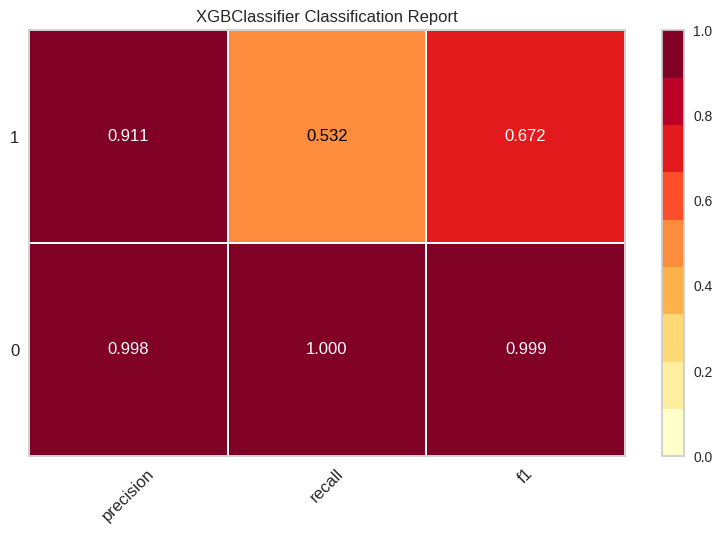

ClassificationReport(ax=<Axes: title={'center': 'XGBClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f9b0c068d00>,
                     estimator=Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['amt',
                                                                                  'age',
                                                                                  'month',
                                                                                  'hour',
                                                                                  'quart...
                                                              grow_policy=None,
                                                              importance_type=None,
                                                              interaction_constraints=None,
                                                              is_unbalanced=True,
                                                              learning_rate=0.1,
                                                              max_bin=None,
                                                              max_cat_threshold=None,
                                                              max_cat_to_onehot=None,
                                                              max_delta_step=None,
                                                              max_depth=15,
                                                              max_leaves=None,
                                                              min_child_weight=None,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              multi_strategy=None,
                                                              n_estimators=None,
                                                              n_jobs=None,
                                                              num_parallel_tree=None, ...))]))

In [93]:
#classification report do modelo de Xgboost
classification_report(pipe_final1, x_train, y_train, x_test, y_test)

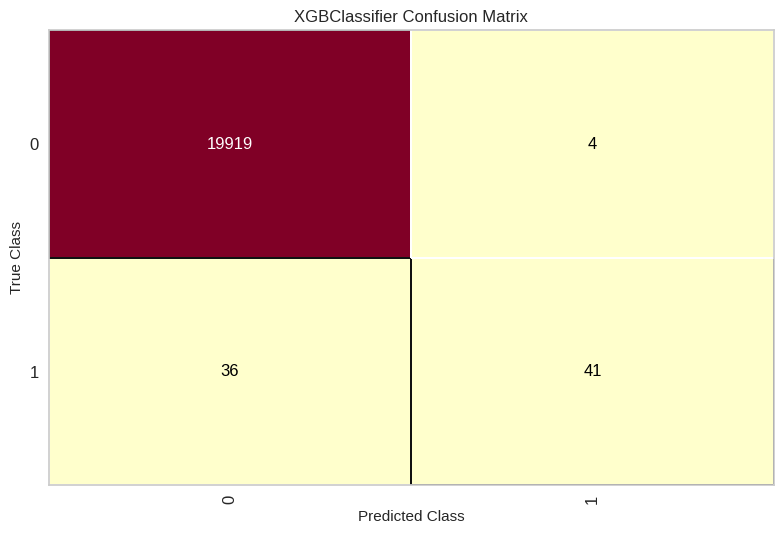

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [94]:
#Confusion Matrix do modelo XGBOOST

matrix=ConfusionMatrix(pipe_final1)
matrix.fit(x_train, y_train)
matrix.score(x_test, y_test)
matrix.show()

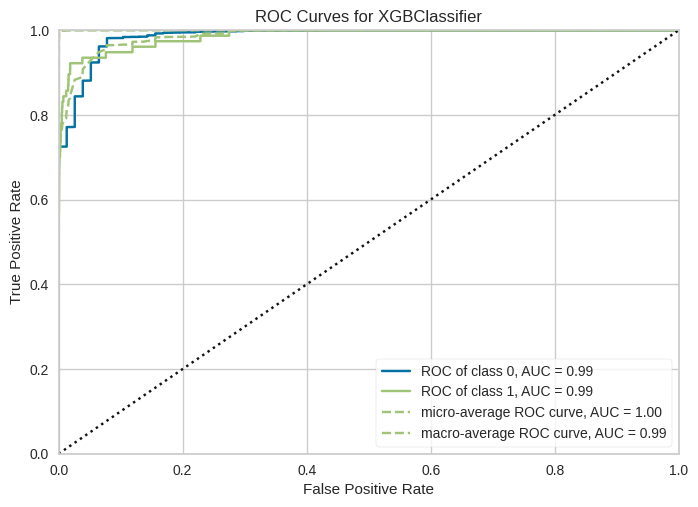

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [95]:
#ROCAUC XGBOOST

curve=ROCAUC(pipe_final1)
curve.fit(x_train, y_train)
curve.score(x_test, y_test)
curve.show()

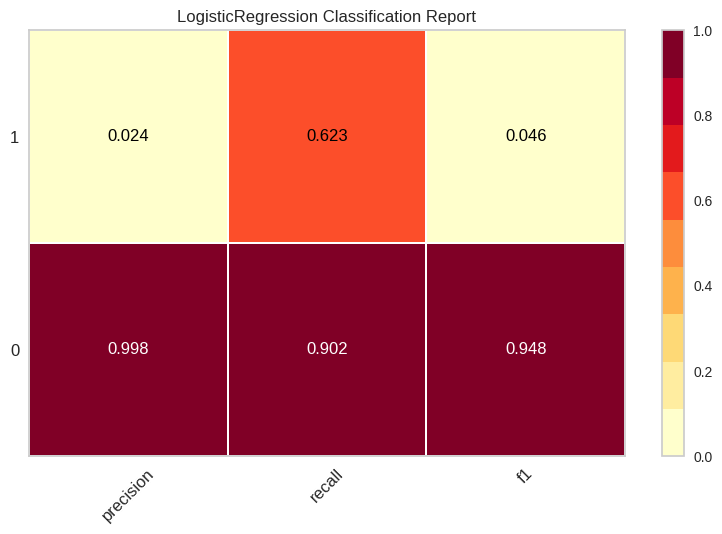

ClassificationReport(ax=<Axes: title={'center': 'LogisticRegression Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f9b0bde6860>,
                     estimator=Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('scaler',
                                                                                                  MinMaxScaler())]),
                                                                                 ['amt',
                                                                                  'age',
                                                                                  'month',
                                                                                  'hour',
                                                                                  '...
                                                                                  'age_seg']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('encoder',
                                                                                                  OneHotEncoder(drop='if_binary',
                                                                                                                handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 ['merchant',
                                                                                  'category',
                                                                                  'gender',
                                                                                  'city',
                                                                                  'state',
                                                                                  'job',
                                                                                  'day_name',
                                                                                  'q_end'])])),
                                               ('lr',
                                                LogisticRegression(C=0.012743,
                                                                   class_weight='balanced',
                                                                   penalty='l1',
                                                                   solver='liblinear'))]))

In [96]:
#calssification report do modelo Logisct Regression
classification_report(pipe_finallr, x_train, y_train, x_test, y_test)

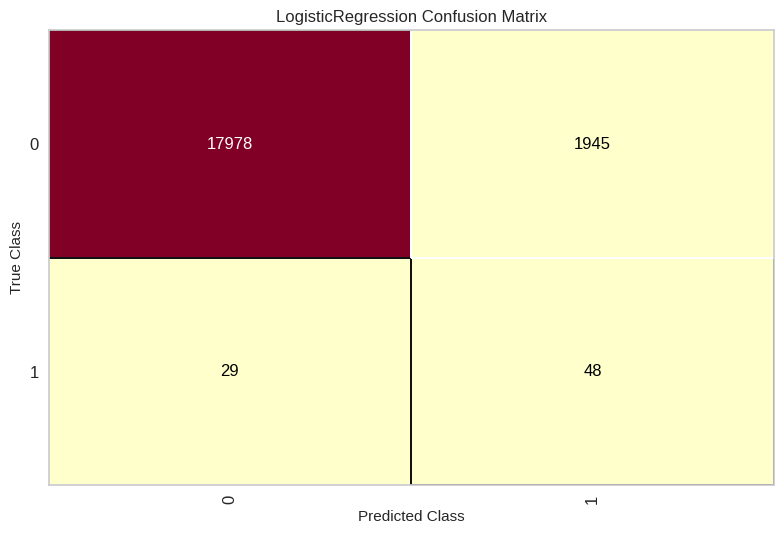

<Axes: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [97]:

matrix=ConfusionMatrix(pipe_finallr)
matrix.fit(x_train, y_train)
matrix.score(x_test, y_test)
matrix.show()

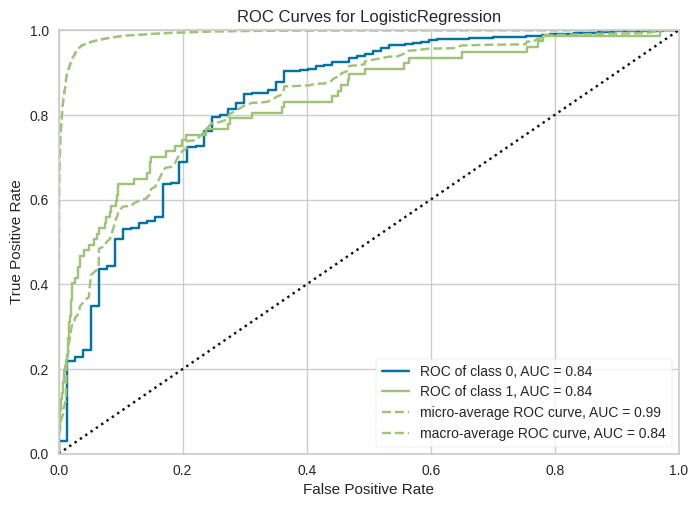

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [87]:
curve=ROCAUC(pipe_finallr)
curve.fit(x_train, y_train)
curve.score(x_test, y_test)
curve.show()